In [22]:
import time
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.decomposition import PCA
from matplotlib import cm
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import torchvision.models as models
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import *
import seaborn as sns
import seaborn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os.path
import random


In [23]:
writer = SummaryWriter()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

from google.colab import drive
drive.mount('/content/gdrive/');
transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),   #must same as here
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



cuda
Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [24]:
def load_Data():
  train_dir = "/content/gdrive/MyDrive/Final_Dataset/dataset1/train"
  test_dir = "/content/gdrive/MyDrive/Final_Dataset/dataset1/test"
  val_dir = "/content/gdrive/MyDrive/Final_Dataset/dataset1/val"
  
  trainset = datasets.ImageFolder(train_dir, transforms_train)
  testset = datasets.ImageFolder(test_dir, transforms_test)
  valset = datasets.ImageFolder(val_dir, transforms_test)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=8)
  testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=8)
  valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False, num_workers=8)
  return trainloader,testloader,valloader
load_Data()

(<torch.utils.data.dataloader.DataLoader at 0x7fcd522f1d60>,
 <torch.utils.data.dataloader.DataLoader at 0x7fcd522f1790>)

In [25]:
# def Model():
#   # Define the ResNet-18 model
#   resnet = 
#   # Replace the last fully connected layer with a new one
#   num_ftrs = resnet.fc.in_features
#   print(num_ftrs)
#   resnet.fc = nn.Linear(num_ftrs,2)

#   # Define the loss function and optimizer
#   return resnet
# Model()


In [26]:
class Resnet18(nn.Module):
    def __init__(self,inputDims) -> None:
        super(Resnet18 , self).__init__()

        self.model = torchvision.models.resnet18(pretrained=True)

        self.fc_layer = nn.Sequential(
            
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),

            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),

            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),

            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),

            nn.Linear(32, 2)
        )
        
        self.model.fc = self.fc_layer
        self.features = {}
        self.model.avgpool.register_forward_hook(self.get_features("embeddings"))

    def get_features(self,name):
        def hook(model, input, output):
            self.features[name] = output.detach().cpu().numpy()
        return hook

    def forward(self, x):
          x = self.model(x)
          return x
model2 = Resnet18((224,224))
print(model2)


Resnet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [27]:
def save_checkpoint(state, filename):
  torch.save(state, filename)


In [28]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [29]:
# datastructure to store all the training testing and validation results.
y_train = []
y_expected_train = []
y_val = []
y_expected_val = []
y_test = []
y_expected_test = []
trainloss = []
valloss =[]
epochnum = []  

In [30]:
print(torch.cuda.is_available())
def train(model, train_loader, criterion, optimizer, epoch, step=5):
    
    model.train()
    loss_list = AverageMeter()
    for i, (images, labels) in enumerate(train_loader):
        #print(torch.cuda.is_available())
        total =0
        correct = 0
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        #print(predicted,type(predicted))
        #print(labels,type(labels))
        output = model(images)
        loss = criterion(output,labels)
        loss_list.update(loss.data, images.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(output.data, 1)
        y_train.extend(predicted.to(torch.device('cpu')))
        y_expected_train.extend(labels.to(torch.device('cpu')))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        #print( f'Training Accuracy: {accuracy:.2f}%')
            
        if i%step==0:
            print('EPOCH {} | ITER {} | AVG_LOSS {} | Train_ACC {}'.format(epoch, i, loss_list.avg,accuracy))
        writer.add_scalar('TRAIN_LOSS', loss, epoch)
        writer.add_scalar('TRAIN_ACC', accuracy, epoch)
        
    return loss ,accuracy

True


In [31]:
def test(model, test_loader, criterion, optimizer, epoch, step=5):
    print("Best Model: ",epoch)
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        print("*"*40)
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            
            #print("Inside test");
            #print(inputs.shape)
            #print(labels.shape)
            labels = labels.to(device)
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs.data, 1)
            #print(predicted,type(predicted))
            #print(labels,type(labels))
            y_test.extend(predicted.to(torch.device('cpu')))
            y_expected_test.extend(labels.to(torch.device('cpu')))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f'test Accuracy: {accuracy:.2f}%')
        # writer.add_scalar('_LOSS', loss, epoch)
        # writer.add_scalar('TEST_ACC', accuracy, epoch)
        return accuracy
    

In [32]:
def val(model, val_loader, criterion, optimizer, epoch, step=5):
    model.eval()
    loss_list = AverageMeter()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            #print("Inside validation");
            #print(inputs.shape)
            #print(labels.shape)
            labels = labels.to(device)
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs.data, 1)
            #print(predicted,type(predicted))
            #print(labels,type(labels))
            loss = criterion(outputs,labels)
            loss_list.update(loss.data, inputs.size(0))
            y_val.extend(predicted.to(torch.device('cpu')))
            y_expected_val.extend(labels.to(torch.device('cpu')))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            #print("CORRECT",correct)
            #print("Total",total)
        accuracy = 100 * correct / total
        print(f'Val Accuracy: {accuracy:.2f}%')
        # writer.add_scalar('Validation_LOSS', loss, epoch)
        writer.add_scalar('Validation_ACCURACY', accuracy, epoch)
        return loss,accuracy
    

In [33]:
def visualize(model , data_loader):
    class2idx = {'Cat': 0, 'Dog': 1}
    idx2class = { value : key for key,value in  class2idx.items() }
    embeddings = np.array([])
    labels = np.array([])
    model.eval()
    out_features = 512
    num_categories = 2
    with torch.no_grad(): 
        for i,data in enumerate(data_loader):
            images, labs = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            embeds = model.features["embeddings"].reshape(-1, 1024)
            embeddings = np.append(embeddings , embeds)
            labels = np.append(labels,labs.cpu())
  
    embeddings = embeddings.reshape(-1, 512)
    
    c_labels = labels.reshape(-1 , 1).ravel()
    tsne = TSNE(n_components=2,perplexity=2).fit_transform(embeddings)
    labels = np.array([ idx2class[ele] for ele in c_labels])
    
    cmap = cm.get_cmap('tab20')
    
    for lab in range(num_categories):
        indices = (c_labels == lab)
        plt.scatter(tsne[indices, 0],tsne[indices, 1],c=np.array(cmap(lab)).reshape(1, 4),label=lab,alpha=1)
        plt.legend(fontsize='large', markerscale=2)
    plt.show()
  
# model = Model((224,224))
# train_loader, val_loader ,test_loader = load_Data()
# visualize(model,test_loader)


In [34]:
def plotloss():
  plt.figure(figsize=(20,10))
  plt.plot(epochnum, trainloss)
  plt.plot(epochnum, valloss)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['training', 'validation'], loc='upper right')
  plt.show()


In [35]:
class2idx = {'Cat':0,'Dog':1}
idx2class = { value : key  for key , value in class2idx.items() }

def plot_confusion_matrix(data, labels, metrics ,output_filename=None):

    [macro_precision , micro_precision , macro_recall , micro_recall] = metrics

    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(10,10))
 
    plt.suptitle("Confusion Matrix")
    plt.title(f"(Macro/Micro) Precision : {round(macro_precision,2)}/{round(micro_precision,2)}   :::::   (Macro/Micro) Recall : {round(macro_recall,2)}/{round(micro_recall,2)}")
 
    seaborn.set(font_scale=1)
    ax = seaborn.heatmap(data, annot=True, cmap="YlGnBu",linewidths=2 , fmt='d' ,cbar_kws={'label': 'Scale'})
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
    
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()



True
using gpu
EPOCH 0 | ITER 0 | AVG_LOSS 0.6789107918739319 | Train_ACC 59.375
EPOCH 0 | ITER 5 | AVG_LOSS 0.6482561826705933 | Train_ACC 46.875
EPOCH 0 | ITER 10 | AVG_LOSS 0.6124029755592346 | Train_ACC 71.875
EPOCH 0 | ITER 15 | AVG_LOSS 0.5882582068443298 | Train_ACC 68.75
EPOCH 0 | ITER 20 | AVG_LOSS 0.574416995048523 | Train_ACC 59.375
EPOCH 0 | ITER 25 | AVG_LOSS 0.5628898739814758 | Train_ACC 84.375
EPOCH 0 | ITER 30 | AVG_LOSS 0.5610732436180115 | Train_ACC 68.75
EPOCH 0 | ITER 35 | AVG_LOSS 0.5478302240371704 | Train_ACC 87.5
EPOCH 0 | ITER 40 | AVG_LOSS 0.5293108224868774 | Train_ACC 90.625
EPOCH 0 | ITER 45 | AVG_LOSS 0.5201600193977356 | Train_ACC 87.5
EPOCH 0 | ITER 50 | AVG_LOSS 0.5188992619514465 | Train_ACC 75.0
EPOCH 0 | ITER 55 | AVG_LOSS 0.5139434337615967 | Train_ACC 75.0
EPOCH 0 | ITER 60 | AVG_LOSS 0.5093635320663452 | Train_ACC 78.125
EPOCH 0 | ITER 65 | AVG_LOSS 0.50568687915802 | Train_ACC 62.5
EPOCH 0 | ITER 70 | AVG_LOSS 0.502386212348938 | Train_ACC 56.25

<ipython-input-33-21ea961f37fa>:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


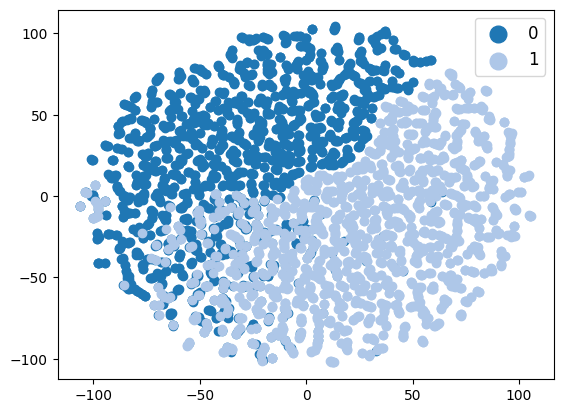

In [36]:
def main():
    model = Resnet18((224,224));
    print(torch.cuda.is_available())
    if torch.cuda.is_available():
        model = model.cuda()
        print("using gpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs = 30
    train_loader, val_loader ,test_loader = load_Data()
 
    history = open("/content/gdrive/MyDrive/Results/finetunedataset1_Resnet18_history.csv",'w')
    history.write('epochs , trainloss , Train-acc,val_acc , test_acc \n')
    max_accuracy = 0 
    finalepoch  = 0 
    for epoch in range(0,epochs):
        start = time.time()
        train_loss,accuracy = train(model, train_loader, criterion, optimizer, epoch)
        vallosss,val_loss = val(model, val_loader, criterion, optimizer, epoch)
        
        trainloss.append(train_loss.cpu().detach().numpy())
        valloss.append(vallosss.cpu().detach().numpy())
        epochnum.append(epoch)
        print()
        print('-' * 50)
        print('EPOCH {} | LOSS {} | TIME {}'.format(epoch, train_loss, time.time() - start))
        print('-' * 50)
        print()

        if(val_loss > max_accuracy):
          max_accuracy = val_loss
          finalepoch  = epoch
          save_checkpoint({'epoch': epoch,'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),'loss' : train_loss}, "/content/gdrive/MyDrive/Checkpoints/finetunedataset1_Resnet18_checkpoint.ckpt")

        history.write('{},{},{},{}\n'.format(epoch, train_loss,accuracy, val_loss ))
    test_loss = test(model, test_loader, criterion, optimizer, finalepoch)    
    history.close()
    visualize(model,train_loader)

# Press the green button in the gutter to run the script.
if __name__ == '__main__':
    main()


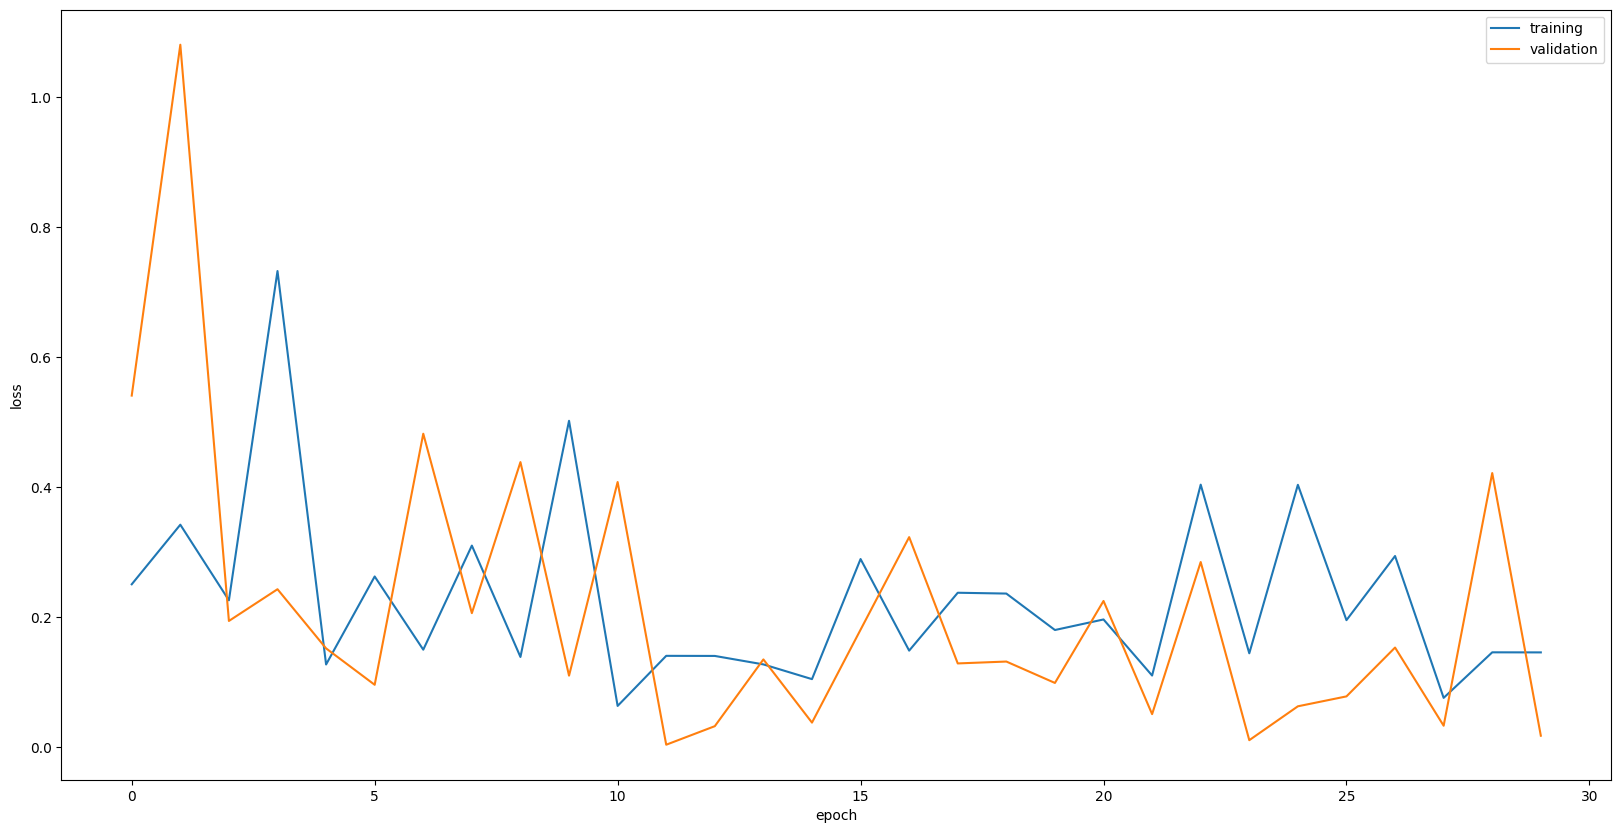

In [37]:
plotloss()

f1 - Score is :---  0.93


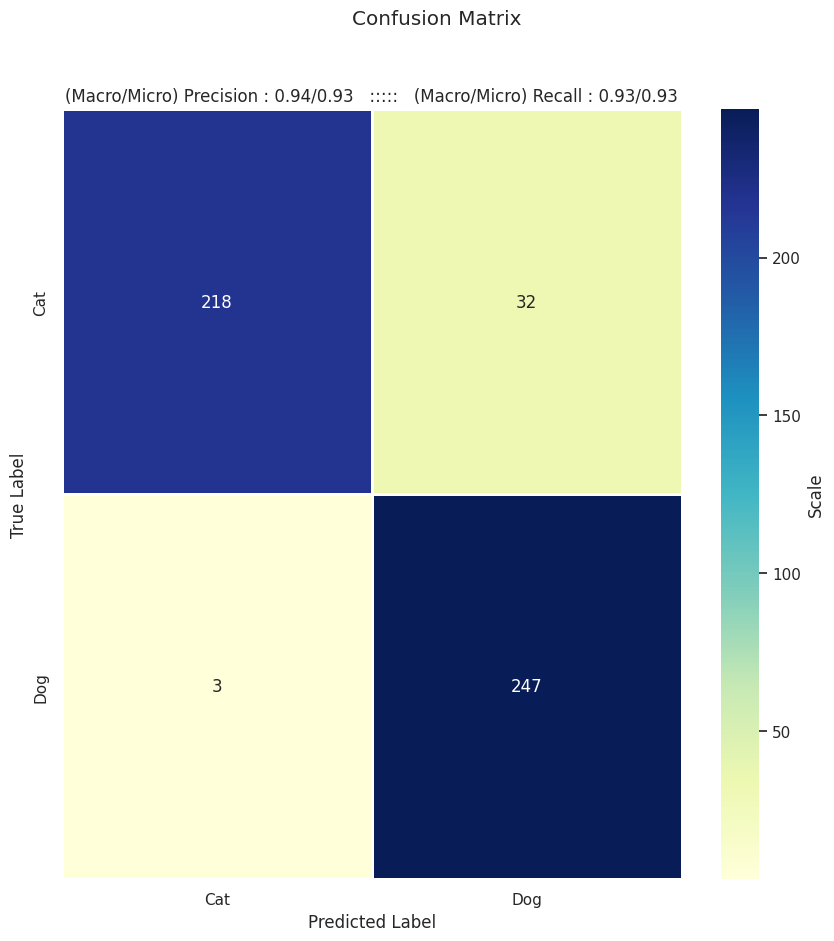

In [38]:
class2idx = {'Cat': 0, 'Dog': 1}

idx2class = { value : key  for key , value in class2idx.items() }
y_true = [idx2class[val.item()] for val in y_expected_test ]
y_pred = [idx2class[val.item()] for val in y_test ]


macro_precision = precision_score(y_true, y_pred, average="macro")
macro_recall = recall_score(y_true, y_pred, average="macro")
micro_precision = precision_score(y_true, y_pred, average="micro")
micro_recall = recall_score(y_true, y_pred, average="micro")
f1_score = (2*micro_precision*micro_recall)/(micro_recall + micro_precision)

print("f1 - Score is :--- " ,f1_score)
cnf_matrix = confusion_matrix(y_true , y_pred , labels=['Cat','Dog'])
plot_confusion_matrix(cnf_matrix , class2idx.keys() , [macro_precision , micro_precision , macro_recall , micro_recall], output_filename = "finetunecnf_resnet_Data1.png")